In [1]:
import scipy.io as sio
import tensorflow as tf

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense, ReLU, BatchNormalization, Flatten, Reshape, Conv2D
from tensorflow.keras.layers import UpSampling2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from numpy import zeros, reshape, mean, array, squeeze, expand_dims, abs, angle, argmax
from numpy.linalg import norm
import os
import datetime
import mat73
from pickle import dump, load

In [2]:
# Load dataset from matlab
SNR = 20
dataset_size = 50_000
num_epochs = 50

path_to_data = f'{os.getcwd()}/Datasets/'
filename = f'{path_to_data}pucch_data_{SNR}dB_{int(dataset_size/1000)}k.mat'

data = sio.loadmat(filename)
X = data['X']
Y = data['Y']
print(X.shape)
print(Y.shape)

(50000, 24)
(50000, 1)


In [3]:
Z = zeros((len(Y), 1))
for i in range (len(Y)):
    if Y[i] == 3:
        Z[i] = 1
    elif Y[i] == 6:
        Z[i] = 2
    elif Y[i] == 9:
        Z[i] = 3

Z = to_categorical(Z)
print(Z)

[[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


In [4]:
# Split datasets into training and testing
num_train = int(0.75 * dataset_size)
num_test = int(dataset_size - num_train)

x_train, x_test = X[0: num_train, :], X[num_train:, :]
y_train, y_test = Y[0: num_train, :], Y[num_train:, :]
z_train, z_test = Z[0: num_train, :], Z[num_train:, :]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 24)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                800       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 34/525 [>.............................] - ETA: 2s - loss: 1.2138 - accuracy: 0.4141

2022-03-23 09:24:37.967934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


523/525 [============================>.] - ETA: 0s - loss: 0.4076 - accuracy: 0.9301

2022-03-23 09:24:40.478530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


525/525 [==============================] - 3s 6ms/step - loss: 0.4064 - accuracy: 0.9302 - val_loss: 0.0985 - val_accuracy: 0.9950
Epoch 2/10
525/525 [==============================] - 3s 6ms/step - loss: 0.0803 - accuracy: 0.9954 - val_loss: 0.0455 - val_accuracy: 0.9957
Epoch 3/10
525/525 [==============================] - 3s 6ms/step - loss: 0.0458 - accuracy: 0.9973 - val_loss: 0.0308 - val_accuracy: 0.9964
Epoch 4/10
525/525 [==============================] - 3s 6ms/step - loss: 0.0325 - accuracy: 0.9982 - val_loss: 0.0240 - val_accuracy: 0.9965
Epoch 5/10
525/525 [==============================] - 3s 6ms/step - loss: 0.0254 - accuracy: 0.9987 - val_loss: 0.0200 - val_accuracy: 0.9970
Epoch 6/10
525/525 [==============================] - 3s 7ms/step - loss: 0.0209 - accuracy: 0.9989 - val_loss: 0.0174 - val_accuracy: 0.9971
Epoch 7/10
525/525 [==============================] - 5s 9ms/step - loss: 0.0178 - accuracy: 0.9990 - val_loss: 0.0155 - val_accuracy: 0.9972
Epoch 8/10
525/52

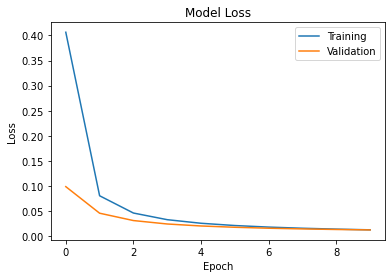

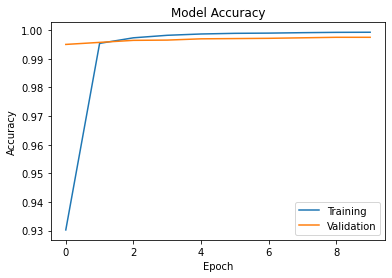

In [6]:
# Build Neural Network and Train
input_signal = Input(shape=(24,), name='input_layer')
x = Dense(32, activation='relu')(input_signal)
x = Dense(32, activation='relu')(x)
output_pred = Dense(4, activation='softmax')(x)

model = Model(input_signal, output_pred)
model.summary()
 
model.compile(optimizer='SGD', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(x_train, z_train, epochs=num_epochs, batch_size=50, validation_split=0.3)


plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="upper right")

plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="lower right")

In [7]:
test_loss, test_acc = model.evaluate(x_test,  z_test, verbose=2)

print('\nTest accuracy:', test_acc)

2022-03-23 09:25:35.289505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


391/391 - 2s - loss: 0.0137 - accuracy: 0.9992

Test accuracy: 0.9992000460624695


In [8]:
predictions = model.predict(x_test)
print(predictions.shape)

2022-03-23 09:25:38.463313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(12500, 4)


In [9]:
predictions[0]

array([1.8002538e-09, 1.7356607e-08, 7.8782190e-09, 1.0000000e+00],
      dtype=float32)

In [10]:
z_test[0]

array([0., 0., 0., 1.], dtype=float32)

In [11]:
def plot_value_array(i, predictions_array, true_label):
    possible_CS = [0, 3, 6, 9]
    
    applied_CS_plt_label = argmax(true_label[i, :])
    applied_CS = possible_CS[applied_CS_plt_label]
    
    recovered_CS_plt_label = argmax(predictions_array)
    recovered_CS = possible_CS[recovered_CS_plt_label]
    
    plt.grid(False)
    
    print(predictions_array)
    thisplot = plt.bar(range(4), predictions_array, color="#777777")
    xtick_labels = ['NACK, -ve SR (0)', 'NACK, +ve SR (3)', 'ACK, -ve SR (6)', 'ACK, +ve SR (9)']
    plt.xticks(range(4), xtick_labels, rotation='vertical')
    # ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=18)
    plt.yticks([])
    plt.ylim([0, 1])
    
    print(thisplot[0])  
    print(applied_CS, recovered_CS)
    thisplot[applied_CS_plt_label].set_color('red')
    thisplot[recovered_CS_plt_label].set_color('blue')

[1.9898782e-04 9.7308162e-04 1.7923042e-04 9.9864870e-01]
Rectangle(xy=(-0.4, 0), width=0.8, height=0.000198988, angle=0)
9 9


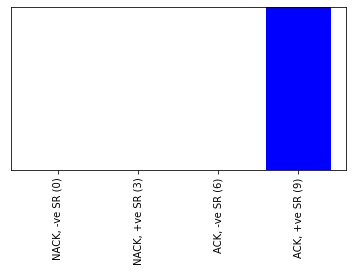

[4.5390738e-05 9.9979967e-01 6.3633554e-05 9.1338028e-05]
Rectangle(xy=(-0.4, 0), width=0.8, height=4.53907e-05, angle=0)
3 3


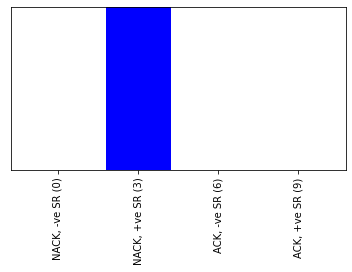

[1.6058895e-05 9.9989021e-01 8.4516078e-06 8.5184365e-05]
Rectangle(xy=(-0.4, 0), width=0.8, height=1.60589e-05, angle=0)
3 3


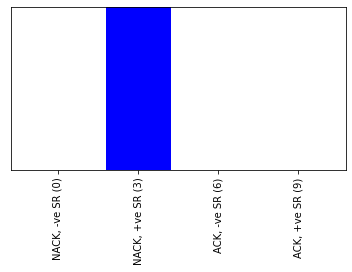

[6.3798898e-06 4.4885222e-05 1.3018769e-05 9.9993563e-01]
Rectangle(xy=(-0.4, 0), width=0.8, height=6.37989e-06, angle=0)
9 9


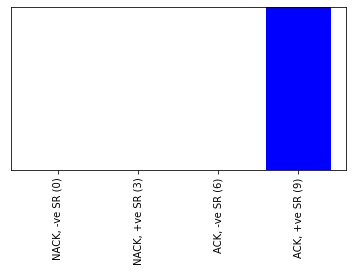

In [12]:
i = 45

for i in [5, 15, 150, 1500]:
    plt.figure(figsize=(6,3))
    plot_value_array(i, predictions[i],  z_test)
    plt.show()